# About

While model training curves can give an idea of how well trained the model is, it is important to evaluate the trained model on data that it has not seen before. In the previous notebook, you explored the trained model, generated predictions on the test dataset and visualized some of these predictions. However, visually examining model performance on a few cases is not enough to gain an understanding of the overall model performance. In this notebook, you will first learn how to rigorously test model performance at an aggregate-level. Next, you will examine performance when the data is stratified - based on tumor grades, patient demographics and hospital sites.

# Learning Objectives

> In this file, you will learn the following:
>    
><ol>
>  <li>Evaluating performance with Segmentation Metrics</li>
>  <li>Model performance on different grades of tumor</li>
>  <li>Model performance on different patient populations</li>
>  <li>Model performance on MRI scans from different hospitals</li>
></ol>

## Imports

In [1]:
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import importlib.util
import keras
import sys
import numpy as np
from sklearn.metrics import *
import seaborn as sns

In [2]:
from __main__ import *
import tensorflow as tf
# import tensorflow_io as tfio
# import tensorflow_probability as tfp
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print(tf.__version__)
print('Listing all GPU resources:')
print(tf.config.experimental.list_physical_devices('GPU'))
print()
import tensorflow.keras as keras 
# print(tfp.__version__)
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import pickle
import os
import sys
import importlib.util
from utils import *

2.9.1
Listing all GPU resources:
[]

2.9.1
Listing all GPU resources:
[]



2022-06-30 16:11:22.140421: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /sw/arcts/centos7/cuda/11.5.1/extras/CUPTI/lib64:/sw/arcts/centos7/cuda/11.5.1/lib64:/opt/slurm/lib64:::/usr/local/cuda/extras/CUPTI/lib64
2022-06-30 16:11:22.140453: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-30 16:11:22.140478: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (armis2-login1.arc-ts.umich.edu): /proc/driver/nvidia/version does not exist


In [3]:
UNet = ModelLoader()
data = DataLoader()

/home/snehalbp/BDSI_2022_ML/BdsiEnv/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.24.1 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
model = UNet.make_model()

2022-06-30 16:11:23.250646: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



Input size: (None, 144, 144, 4)
Output size: (None, 144, 144, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 144, 144, 4  0           []                               
                                )]                                                                
                                                                                                  
 encoder_1_a (Conv2D)           (None, 144, 144, 32  1184        ['input_layer[0][0]']            
                                )                                                                 
                                                                                                  
 encoder_1_b (Conv2D)           (None, 144, 144, 32  9248        ['encoder_1_a[0][0]']            
                            

                                )                                                                 
                                                                                                  
 decoder_1_b (Conv2D)           (None, 144, 144, 32  9248        ['decoder_1_a[0][0]']            
                                )                                                                 
                                                                                                  
 last_layer (Conv2D)            (None, 144, 144, 1)  33          ['decoder_1_b[0][0]']            
                                                                                                  
 activation (Activation)        (None, 144, 144, 1)  0           ['last_layer[0][0]']             
                                                                                                  
Total params: 7,848,865
Trainable params: 7,847,905
Non-trainable params: 960
_______________________________

## 1. Evaluating performance with Segmentation Metrics

There exist a plethora of metrics to evaluate the performance of a medical image segmentation algorithm. Each metric focuses on a specific aspect of the algorithm's performance, and is thus limited in capability to describe the algorithm's performance by itself. Several metrics are necessary to describe comprehensive characteristics of segmentation performance.

Here, we compute the metrics for a single patient in the test dataset.

In [5]:
patient_case = 'TCGA-HT-7874'

In [6]:
patient = Patient(data,UNet)
patient.create(patient_case)
patient.get_information()

,Case,Tissue source site,Study,Histology,Grade,Age (years at diagnosis),Gender,Survival (months),Vital status (1=dead)
282,TCGA-HT-7874,Case Western - St Joes,Brain Lower Grade Glioma,oligodendroglioma,G3,41.0,female,37.126037,0.0


Let's see how some of the MRI scans look like, along with radiologist-annotated tumor and the model's predictions

In [7]:
# MRI = patient.get_datafiles()[0]
# # patient.prediction_data = UNet.predict_and_calibrate(MRI)[:,1].reshape(patient.label_data.shape)

In [8]:
# patient.prediction_data = UNet.predict_and_calibrate(MRI)[:,1].reshape(patient.label_data.shape)

5/5 [==============================] - 4s 679ms/step


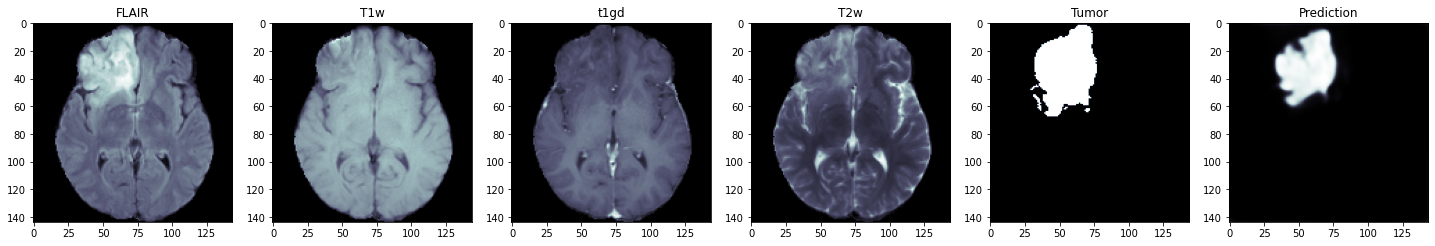

5/5 [==============================] - 4s 692ms/step


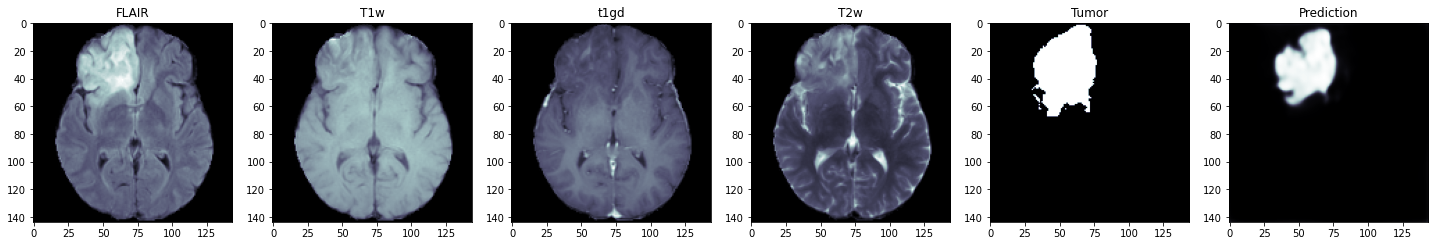

5/5 [==============================] - 4s 693ms/step


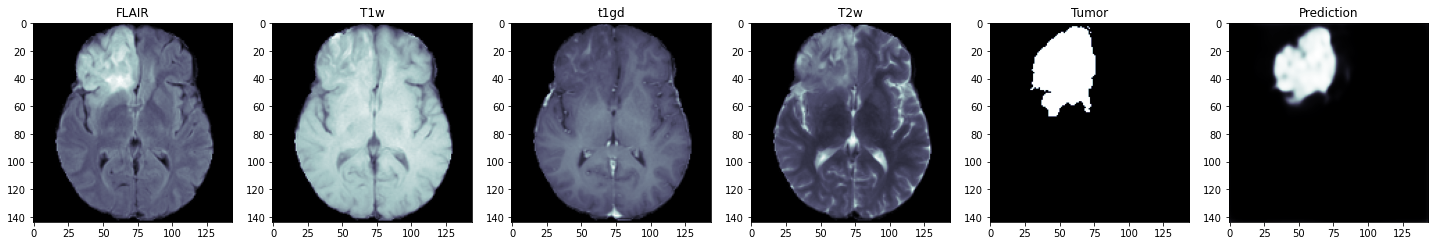

5/5 [==============================] - 4s 697ms/step


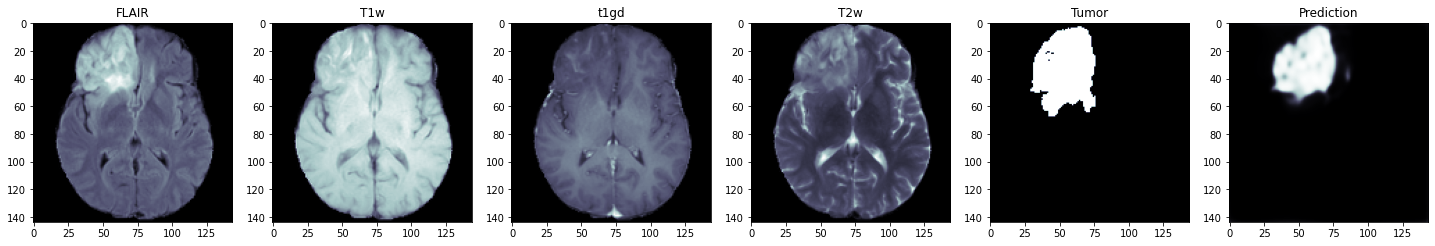

5/5 [==============================] - 4s 685ms/step


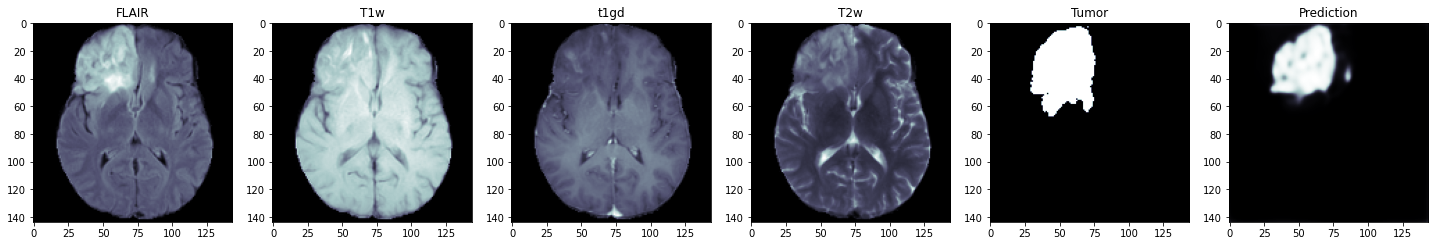

5/5 [==============================] - 4s 682ms/step


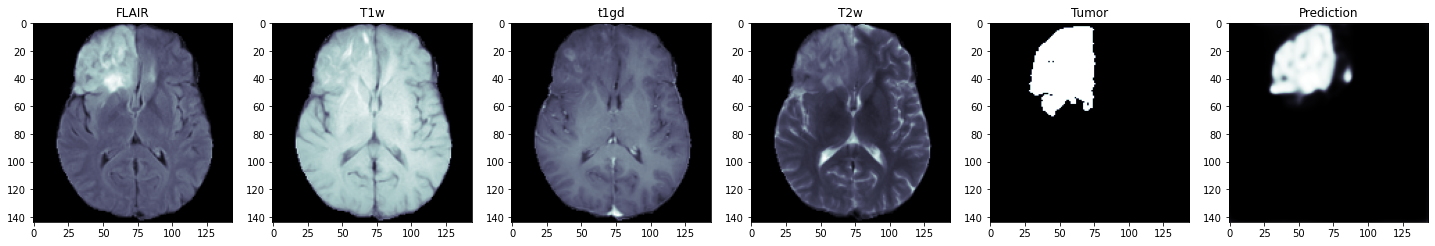

5/5 [==============================] - 4s 700ms/step


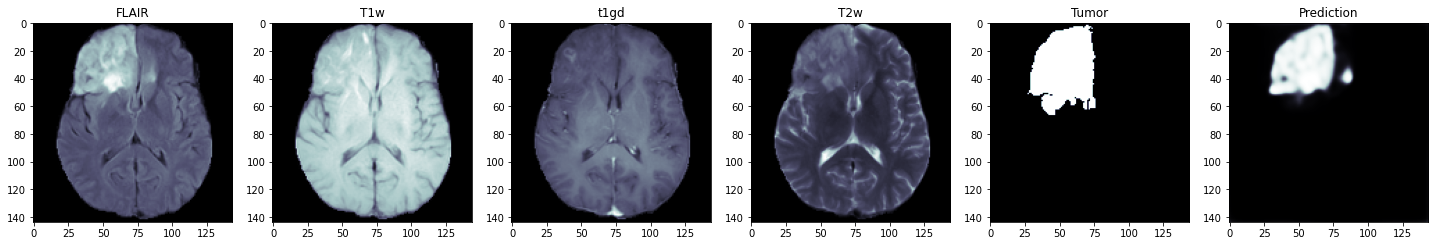

5/5 [==============================] - 4s 685ms/step


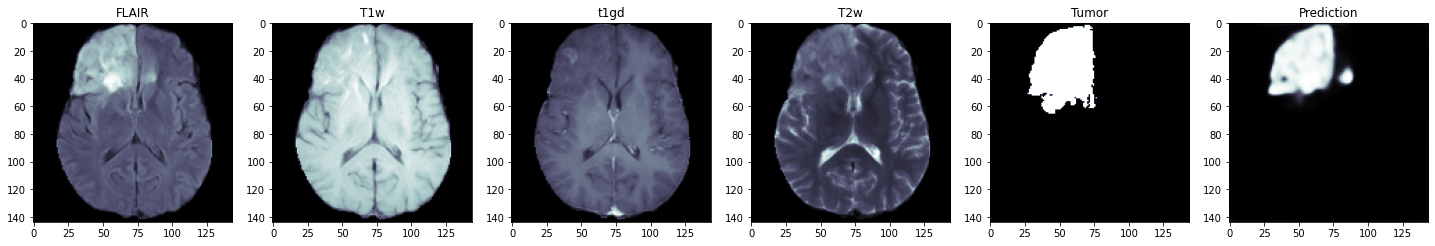

5/5 [==============================] - 4s 677ms/step


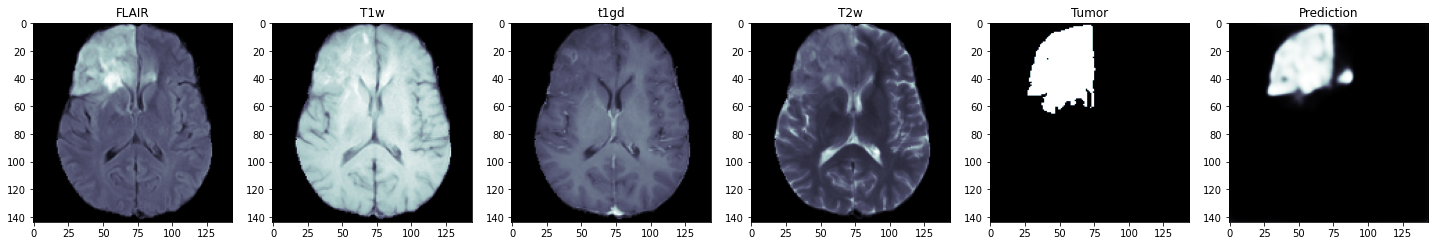

5/5 [==============================] - 4s 689ms/step


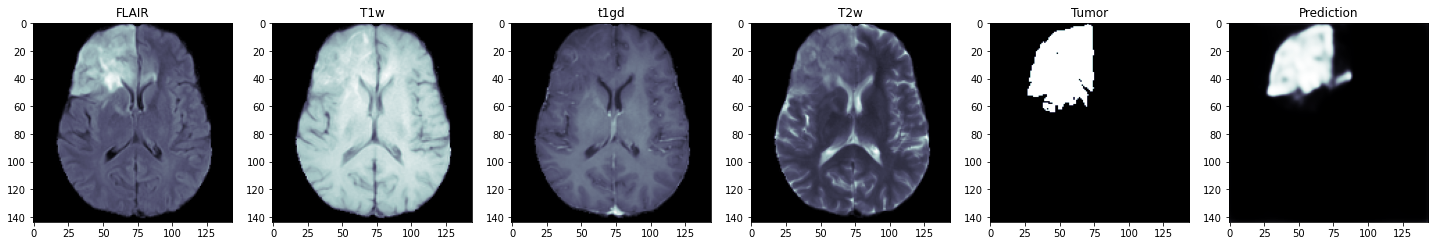

In [9]:
for z_slice in range(70,80):
    patient.plot_figures(z_slice)

In [ ]:
y_prob = patient.prediction_data.ravel()
y_true = patient.label_data.ravel()
y_pred = (y_prob > .5).astype(int)   #predicted binary label

In [ ]:
metrics = Metrics(patient)
metrics.confusion_matrix(plot=True)

In [ ]:
_, _ = metrics.classical_metrics(verbose=True)

In [ ]:
_, _ = metrics.similarity_metrics(verbose=True)

## 2. Model performance on different grades of tumor

## 3. Model performance on different patient populations

## 4. Model performance on MRI scans from different hospitals